In [20]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import src.utils as utils

from src.Data import Data
from src.Camera import Camera
from src.Plot import Plot
from src.VisualOdometry import VisualOdometry

import matplotlib.pyplot as plt

In [21]:
data = Data()
camera = Camera('data/camera.dat')

Ground truth pose: 
 [[1.  0.  0.  0.2]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
Estimated pose: 
 [[ 1.  0.  0. -0.]
 [-0.  1.  0. -0.]
 [-0. -0.  1. -1.]
 [ 0.  0.  0.  1.]]
Estimated pose world frame: 
 [[ 0.  -1.  -0.  -0. ]
 [ 0.   0.  -1.  -0. ]
 [ 1.   0.   0.  -1.2]
 [ 0.   0.   0.   1. ]]
Projected point:  [539.00476138 183.62107366]
Projected point:  [463.68761167 126.44724397]
Projected point:  [ 56.66449957 172.77139324]
Projected point:  [305.32935271 110.54595996]
Projected point:  [518.356 215.216]
Projected point:  [ 59.04470017 233.22799335]
Projected point:  [572.23399394 136.00698531]
Projected point:  [301.93940139 173.80489036]
Projected point:  [174.9810271  157.29395248]
Projected point:  [ 66.33835929 196.22623579]
Projected point:  [476.46709983 192.08932576]
Projected point:  [556.21398938 199.45193819]
Projected point:  [401.51807435 173.53809113]
Projected point:  [449.59802946 216.73516388]
Projected point:  [109.46782465 165.19349336]
Proj

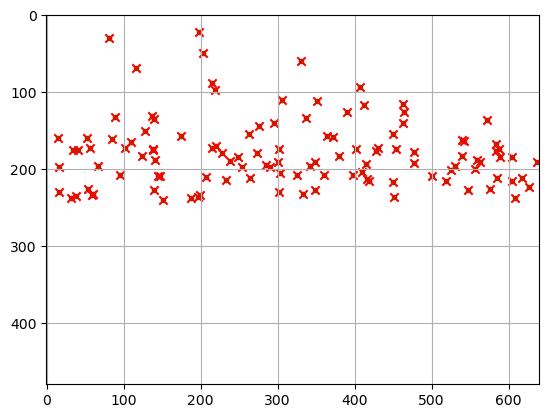

In [22]:
vo = VisualOdometry(camera, data)
vo.initialize()

index = 1

measurements = data.get_measurement_points(index)
matches = vo.data_association(measurements, vo.get_map())
image_points = matches['points_1']
world_points = matches['points_2']
appearances = matches['appearances']

x_gt, y_gt, theta_gt = data.get_trajectory()[index]['ground_truth_pose']
w_T_r = utils.v2T(np.array([x_gt, y_gt, 0, 0, 0, theta_gt]))
print('Ground truth pose: \n', np.round(w_T_r, 2))

r_T_c = camera.get_camera_transform()
estimated_w_T_c = vo.get_trajectory()['poses'][index]
estimated_w_T_r = estimated_w_T_c @ np.linalg.inv(r_T_c)
print('Estimated pose: \n', np.round(estimated_w_T_c, 2))
print('Estimated pose world frame: \n', np.round(estimated_w_T_r, 2))

projected_points = []
projected_points_gt = []
for i in range(len(world_points)):
    proj_image_point_hom, proj_image_point = camera.project_point(world_points[i], estimated_w_T_c)
    print('Projected point: ', proj_image_point)
    
    if proj_image_point_hom is None or proj_image_point is None:
        continue    
    projected_points.append(proj_image_point)

    proj_image_point_hom_gt, proj_image_point_gt = camera.project_point(world_points[i], w_T_r)
    if proj_image_point_hom_gt is None or proj_image_point_gt is None:
        continue
    projected_points_gt.append(proj_image_point_gt)

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='green', marker='.')
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='red', marker='x')
#ax.scatter([point[0] for point in projected_points_gt], [point[1] for point in projected_points_gt], color='blue', marker='*')
plt.grid()
plt.show()

In [23]:
pose_0 = vo.get_trajectory()['poses'][0]
pose_1 = vo.get_trajectory()['poses'][1]

world_points = vo.get_map()['points']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

fig.add_trace(go.Scatter3d(x=[pose_0[0, 3]], y=[pose_0[1, 3]], z=[pose_0[2, 3]], mode='markers', marker=dict(size=4, color='red')))
fig.add_trace(go.Scatter3d(x=[pose_1[0, 3]], y=[pose_1[1, 3]], z=[pose_1[2, 3]], mode='markers', marker=dict(size=4, color='blue')))
fig.add_trace(go.Scatter3d(x=[pose_0[0, 3], pose_1[0, 3]], y=[pose_0[1, 3], pose_1[1, 3]], z=[pose_0[2, 3], pose_1[2, 3],], mode='lines', line=dict(color='black', width=2)))

fig.show()

Number of world points:  115


In [24]:
map = vo.get_map()
points = map['points']

C = camera.get_camera_transform()
points_hom = np.hstack((points, np.ones((len(points), 1))))
points = points_hom @ np.linalg.inv(C)

appearances = map['appearances']
set_1 = {'points': points, 'appearances': appearances}

set_2 = {'points': [], 'appearances': []}
world = data.get_world()
for i in range(len(world)):
    landmark_position = world[i]['landmark_position']
    landmark_appearances = world[i]['landmark_appearance']
    set_2['points'].append(landmark_position)
    set_2['appearances'].append(landmark_appearances)

matches = vo.data_association(set_1, set_2)
map_points = matches['points_1']
world_points = matches['points_2']

x_coords = [point[0]*0.204 for point in map_points]
y_coords = [point[1]*0.204 for point in map_points]
z_coords = [point[2]*0.204 for point in map_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='red')))
fig.show()


In [25]:
for i in range(2,121):
    vo.one_step(i)

image_point [558.97 178.48]
proj_image_point [539.   183.62]
proj_image_point_hom [6453.18 2198.39   11.97]
error [-19.96   5.14]
z_inv_square 0.01
J_icp
 [[  1.   0.   0.   0.  12.   4.]
 [  0.   1.   0. -12.   0.  14.]
 [  0.   0.   1.  -4. -14.   0.]]
J_proj
 [[  0.08   0.   -45.02]
 [  0.     0.08 -15.34]]
J
 [[  15.03    0.    -18.29   73.17  436.51   60.14]
 [   0.     15.03    4.71 -199.25  -65.93  210.48]]


##############################################################
e [-19.96   5.14]
J [[  15.03    0.    -18.29   73.17  436.51   60.14]
 [   0.     15.03    4.71 -199.25  -65.93  210.48]]


image_point [492.84 103.41]
proj_image_point [463.69 126.45]
proj_image_point_hom [2749.    749.65    5.93]
error [-29.16  23.04]
z_inv_square 0.03
J_icp
 [[ 1.  0.  0.  0.  6.  4.]
 [ 0.  1.  0. -6.  0.  4.]
 [ 0.  0.  1. -4. -4.  0.]]
J_proj
 [[  0.17   0.   -78.21]
 [  0.     0.17 -21.33]]
J
 [[  30.36    0.    -24.24   96.95  279.11  121.45]
 [   0.     30.36   19.15 -258.78  -76.61  1

/home/valerio/Documents/University/Probabilisti-Robotics/VisualOdometry/src/VisualOdometry.py:322: RuntimeWarning:

overflow encountered in scalar multiply

/home/valerio/Documents/University/Probabilisti-Robotics/VisualOdometry/src/VisualOdometry.py:328: RuntimeWarning:

invalid value encountered in matmul



LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
estimated_trajectory = vo.get_trajectory()
gt_trajectory = data.get_trajectory()

C = camera.get_camera_transform()
C_inv = np.linalg.inv(C)    

estimated_poses = estimated_trajectory['poses']
estimated_poses_in_world = [] 

for i in range(len(estimated_poses)):
    pose = estimated_poses[i]
    pose_in_world = pose @ C_inv
    estimated_poses_in_world.append(pose_in_world)
    

estimated_positions = []
estimated_positions_in_world = [] 
for i in range(len(estimated_poses_in_world)):
    estimated_positions.append(estimated_poses[i][:3, 3]*0.204)
    estimated_positions_in_world.append(estimated_poses_in_world[i][:3, 3]*0.204)

gt_poses = []
gt_positions = []
for i in range(121):
    x_gt, y_gt, theta_gt = gt_trajectory[i]['ground_truth_pose']
    gt_poses.append(np.array([x_gt, y_gt, 0, 0, 0, theta_gt]))
    gt_positions.append(np.array([x_gt, y_gt, 0]))
    
fig = go.Figure()
gt_x_coords = [position[0] for position in gt_positions]
gt_y_coords = [position[1] for position in gt_positions]
gt_z_coords = [position[2] for position in gt_positions]
#fig.add_trace(go.Scatter3d(x=gt_x_coords, y=gt_y_coords, z=gt_z_coords, mode='lines', name='GT trajectory', line=dict(color='green')))

estimated_x_coords = [position[0] for position in estimated_positions]
estimated_y_coords = [position[1] for position in estimated_positions]
estimated_z_coords = [position[2] for position in estimated_positions]
fig.add_trace(go.Scatter3d(x=estimated_x_coords, y=estimated_y_coords, z=estimated_z_coords, mode='lines', name='Estimated trajectory', line=dict(color='red')))

estimated_x_coords_in_world = [position[0] for position in estimated_positions_in_world]
estimated_y_coords_in_world = [position[1] for position in estimated_positions_in_world]
estimated_z_coords_in_world = [position[2] for position in estimated_positions_in_world]
fig.add_trace(go.Scatter3d(x=estimated_x_coords_in_world, y=estimated_y_coords_in_world, z=estimated_z_coords_in_world, mode='lines', name='Estimated trajectory in world frame', line=dict(color='blue')))

fig.show()

Estimated pose: 
 [[ 1.   0.   0.  -0. ]
 [-0.   1.   0.  -0. ]
 [-0.  -0.   1.   0.8]
 [ 0.   0.   0.   1. ]]


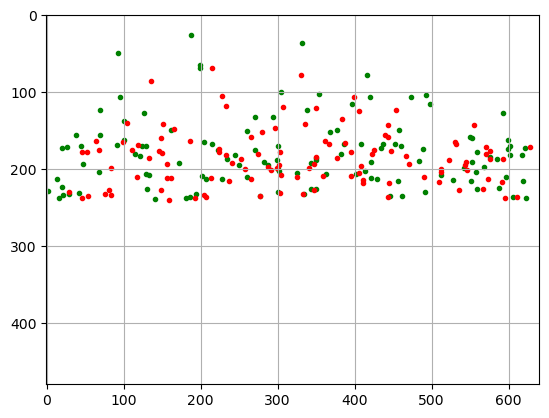

In [ ]:
index = 2

measurements = data.get_measurement_points(index)
matches = vo.data_association(measurements, vo.get_map())
image_points = matches['points_1']
world_points = matches['points_2']
appearances = matches['appearances']

gt_pose = data.get_trajectory()[index]['ground_truth_pose'] + [0, 0, 0]
w_T_r = utils.v2T(np.array(gt_pose))
R = w_T_r[:3, :3]
t = w_T_r[:3, 3]

estimated_w_T_r = vo.get_trajectory()['poses'][index]
print('Estimated pose: \n', np.round(estimated_w_T_r, 2))

# r_T_c = camera.get_camera_transform()
# w_T_c = np.dot(estimated_w_T_r, r_T_c)
# estimated_w_T_r = np.dot(estimated_w_T_r, r_T_c)

projected_points = []
projected_points_gt = []
for i in range(len(world_points)):
    proj_image_point_hom, proj_image_point = camera.project_point(world_points[i])
    if proj_image_point_hom is None or proj_image_point is None:
        continue
    projected_points.append(proj_image_point)

    proj_image_point_hom_gt, proj_image_point_gt = camera.project_point(world_points[i])
    if proj_image_point_hom_gt is None or proj_image_point_gt is None:
        continue
    projected_points_gt.append(proj_image_point_gt)

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='green', marker='.')
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='red', marker='.')
#ax.scatter([point[0] for point in projected_points_gt], [point[1] for point in projected_points_gt], color='blue', marker='*')
plt.grid()
plt.show()

In [ ]:
world_points = vo.get_map()['points']

C = camera.get_camera_transform()
world_points_hom = np.hstack((world_points, np.ones((len(world_points), 1))))
world_points = world_points_hom @ np.linalg.inv(C)
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=1)))

fig.show()

Number of world points:  311
